
# GPU and batched data augmentation with Kornia and PyTorch-Lightning

In this tutorial we will show how to combine both Kornia.org and PyTorch Lightning
to perform efficient data augmentation to train a simpple model using the GPU in batch
mode without additional effort.


---
Open in [![Open In Colab](https://colab.research.google.com/assets/colab-badge.png){height="20px" width="117px"}](https://colab.research.google.com/github/PytorchLightning/lightning-tutorials/blob/publication/.notebooks/lightning_examples/augmentation_kornia.ipynb)

Give us a ⭐ [on Github](https://www.github.com/PytorchLightning/pytorch-lightning/)
| Check out [the documentation](https://pytorch-lightning.readthedocs.io/en/latest/)
| Join us [on Slack](https://join.slack.com/t/pytorch-lightning/shared_invite/zt-pw5v393p-qRaDgEk24~EjiZNBpSQFgQ)

### Setup
This notebook requires some packages besides pytorch-lightning.

In [1]:
! pip install --quiet kornia torchmetrics>=0.3 pandas torch>=1.6, <1.9 matplotlib torchvision pytorch-lightning>=1.3 torchmetrics pytorch-lightning

/bin/sh: 1: cannot open 1.9: No such file


In [2]:
import os

import kornia as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torchmetrics
import torchvision
from pytorch_lightning import Trainer
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

AVAIL_GPUS = min(1, torch.cuda.device_count())

/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/kornia/augmentation/augmentation.py:1830: DeprecationWarning: GaussianBlur is no longer maintained and will be removed from the future versions. Please use RandomGaussianBlur instead.
  warnings.warn(


/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: DeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  warnings.warn(*args, **kwargs)


/usr/local/lib/python3.8/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:572: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (np.object, string),
/usr/local/lib/python3.8/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:573: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (np.bool, bool),
/usr/local/lib/python3.8/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:597: DeprecationWarnin

## Define Data Augmentations module

[Kornia.org](https://www.kornia.org) is low level Computer Vision library that provides a dedicated module
[`kornia.augmentation`](https://kornia.readthedocs.io/en/latest/augmentation.html) module implementing
en extensive set of data augmentation techniques for image and video.

Similar to Lightning, in Kornia it's promoted to encapsulate functionalities inside classes for readability
and efficiency purposes. In this case, we define a data augmentaton pipeline subclassing a `nn.Module`
where the augmentation_kornia (also subclassing `nn.Module`) are combined with other PyTorch components
such as `nn.Sequential`.

Checkout the different augmentation operators in Kornia docs and experiment yourself !

In [3]:
class DataAugmentation(nn.Module):
    """Module to perform data augmentation using Kornia on torch tensors."""

    def __init__(self, apply_color_jitter: bool = False) -> None:
        super().__init__()
        self._apply_color_jitter = apply_color_jitter

        self.transforms = nn.Sequential(
            K.augmentation.RandomHorizontalFlip(p=0.75),
            K.augmentation.RandomChannelShuffle(p=0.75),
            K.augmentation.RandomThinPlateSpline(p=0.75),
        )

        self.jitter = K.augmentation.ColorJitter(0.5, 0.5, 0.5, 0.5)

    @torch.no_grad()  # disable gradients for effiency
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_out = self.transforms(x)  # BxCxHxW
        if self._apply_color_jitter:
            x_out = self.jitter(x_out)
        return x_out

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Define a Pre-processing module

In addition to the `DataAugmentation` modudle that will sample random parameters during the training stage,
we define a `Preprocess` class to handle the conversion of the image type to properly work with `torch.Tensor`.

For this example we use `torchvision` CIFAR10 which return samples of `PIL.Image`, however,
to take all the advantages of PyTorch and Kornia we need to cast the images into tensors.

To do that we will use `kornia.image_to_tensor` which casts and permutes the images in the right format.

In [4]:
class Preprocess(nn.Module):
    """Module to perform pre-process using Kornia on torch tensors."""

    @torch.no_grad()  # disable gradients for effiency
    def forward(self, x) -> torch.Tensor:
        x_tmp: np.ndarray = np.array(x)  # HxWxC
        x_out: torch.Tensor = K.image_to_tensor(x_tmp, keepdim=True)  # CxHxW
        return x_out.float() / 255.

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Define PyTorch Lightning model

The next step is to define our `LightningModule` to have a proper organisation of our training pipeline.
This is a simple example just to show how to structure your baseline to be used as a reference,
do not expect a high performance.

Notice that the `Preprocess` class is injected into the dataset and will be applied per sample.

The interesting part in the proposed approach happens inside the `training_step` where with just a single
line of code we apply the data augmentation in batch and no need to worry about the device.
This means that our `DataAugmentation` pipeline will automatically executed in the GPU.

In [5]:
class CoolSystem(pl.LightningModule):

    def __init__(self):
        super(CoolSystem, self).__init__()
        # not the best model: expereiment yourself
        self.model = torchvision.models.resnet18(pretrained=True)

        self.preprocess = Preprocess()  # per sample transforms

        self.transform = DataAugmentation()  # per batch augmentation_kornia

        self.accuracy = torchmetrics.Accuracy()

    def forward(self, x):
        return F.softmax(self.model(x))

    def compute_loss(self, y_hat, y):
        return F.cross_entropy(y_hat, y)

    def show_batch(self, win_size=(10, 10)):

        def _to_vis(data):
            return K.utils.tensor_to_image(torchvision.utils.make_grid(data, nrow=8))

        # get a batch from the training set: try with `val_datlaoader` :)
        imgs, labels = next(iter(self.train_dataloader()))
        imgs_aug = self.transform(imgs)  # apply transforms
        # use matplotlib to visualize
        plt.figure(figsize=win_size)
        plt.imshow(_to_vis(imgs))
        plt.figure(figsize=win_size)
        plt.imshow(_to_vis(imgs_aug))

    def training_step(self, batch, batch_idx):
        x, y = batch
        x_aug = self.transform(x)  # => we perform GPU/Batched data augmentation
        y_hat = self(x_aug)
        loss = self.compute_loss(y_hat, y)
        self.log("train_loss", loss, prog_bar=False)
        self.log("train_acc", self.accuracy(y_hat, y), prog_bar=False)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.compute_loss(y_hat, y)
        self.log("valid_loss", loss, prog_bar=False)
        self.log("valid_acc", self.accuracy(y_hat, y), prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, self.trainer.max_epochs, 0)
        return [optimizer], [scheduler]

    def prepare_data(self):
        CIFAR10(os.getcwd(), train=True, download=True, transform=self.preprocess)
        CIFAR10(os.getcwd(), train=False, download=True, transform=self.preprocess)

    def train_dataloader(self):
        dataset = CIFAR10(os.getcwd(), train=True, download=True, transform=self.preprocess)
        loader = DataLoader(dataset, batch_size=32)
        return loader

    def val_dataloader(self):
        dataset = CIFAR10(os.getcwd(), train=True, download=True, transform=self.preprocess)
        loader = DataLoader(dataset, batch_size=32)
        return loader

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Visualize images

In [6]:
# init model
model = CoolSystem()

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/AzDevOps_azpcontainer/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0it [00:00, ?it/s]

Extracting /__w/1/s/cifar-10-python.tar.gz to /__w/1/s


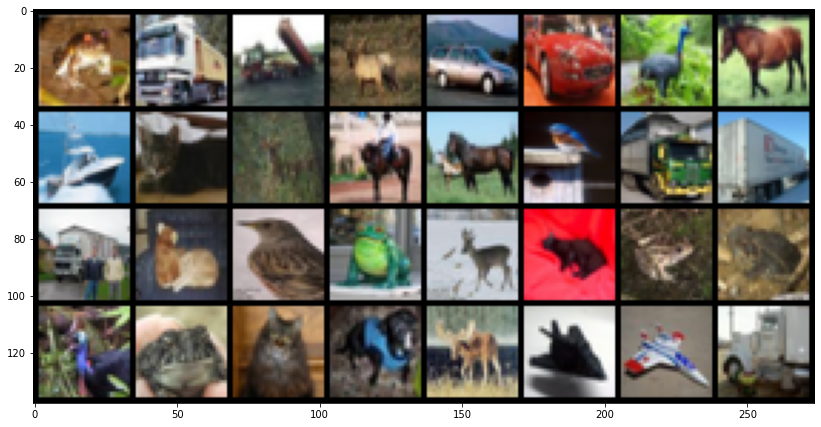

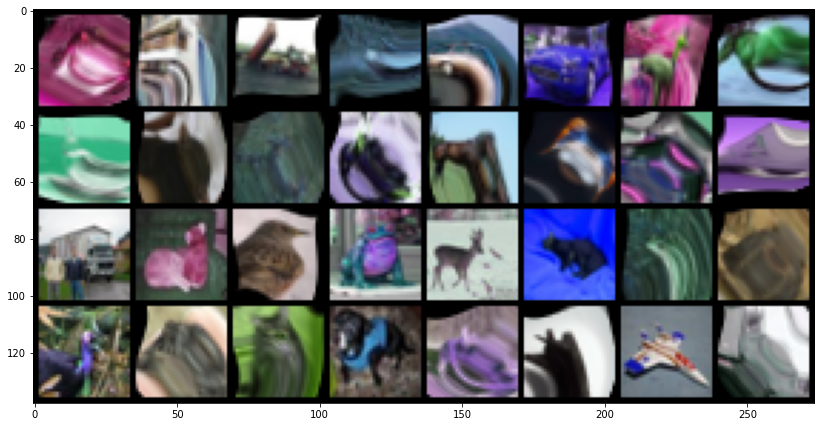

In [7]:
model.show_batch(win_size=(14, 14))

## Run training

In [8]:
# Initialize a trainer
trainer = Trainer(
    progress_bar_refresh_rate=20,
    gpus=AVAIL_GPUS,
    max_epochs=10,
    logger=pl.loggers.CSVLogger(save_dir='logs/', name="cifar10-resnet18")
)

# Train the model ⚡
trainer.fit(model)

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
GPU available: True, used: True


TPU available: False, using: 0 TPU cores


/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: DeprecationWarning: The `LightningModule.datamodule` property is deprecated in v1.3 and will be removed in v1.5. Access the datamodule through using `self.trainer.datamodule` instead.
  warnings.warn(*args, **kwargs)


Files already downloaded and verified


Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



  | Name       | Type             | Params
------------------------------------------------
0 | model      | ResNet           | 11.7 M
1 | preprocess | Preprocess       | 0     
2 | transform  | DataAugmentation | 0     
3 | accuracy   | Accuracy         | 0     
------------------------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
46.758    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Files already downloaded and verified


/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
<ipython-input-5-34f1ad42dd2e>:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.model(x))


Files already downloaded and verified


/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

### Visualize the training results

   train_loss  train_acc  epoch  step  valid_loss  valid_acc
0    6.740019    0.18750      0    49         NaN        NaN
1    6.782853    0.15625      0    99         NaN        NaN
2    6.775434    0.15625      0   149         NaN        NaN
3    6.755668    0.15625      0   199         NaN        NaN
4    6.722195    0.18750      0   249         NaN        NaN


/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

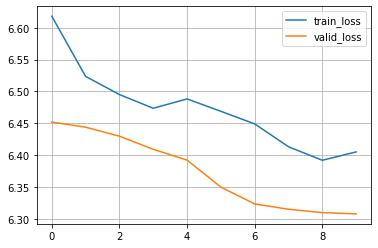

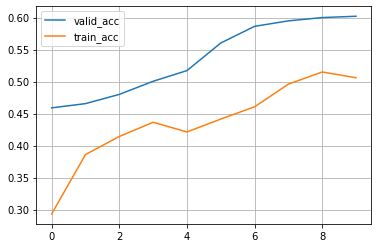

In [9]:
metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')
print(metrics.head())

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[['train_loss', 'valid_loss']].plot(grid=True, legend=True)
df_metrics[['valid_acc', 'train_acc']].plot(grid=True, legend=True)

## Tensorboard

In [10]:
# Start tensorboard.
# %load_ext tensorboard
# %tensorboard --logdir lightning_logs/

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<code style="color:#792ee5;">
    <h1> <strong> Congratulations - Time to Join the Community! </strong>  </h1>
</code>

Congratulations on completing this notebook tutorial! If you enjoyed this and would like to join the Lightning
movement, you can do so in the following ways!

### Star [Lightning](https://github.com/PyTorchLightning/pytorch-lightning) on GitHub
The easiest way to help our community is just by starring the GitHub repos! This helps raise awareness of the cool
tools we're building.

* Please, star [Lightning](https://github.com/PyTorchLightning/pytorch-lightning)

### Join our [Slack](https://join.slack.com/t/pytorch-lightning/shared_invite/zt-pw5v393p-qRaDgEk24~EjiZNBpSQFgQ)!
The best way to keep up to date on the latest advancements is to join our community! Make sure to introduce yourself
and share your interests in `#general` channel


### Contributions !
The best way to contribute to our community is to become a code contributor! At any time you can go to
[Lightning](https://github.com/PyTorchLightning/pytorch-lightning) or [Bolt](https://github.com/PyTorchLightning/lightning-bolts)
GitHub Issues page and filter for "good first issue".

* [Lightning good first issue](https://github.com/PyTorchLightning/pytorch-lightning/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* [Bolt good first issue](https://github.com/PyTorchLightning/lightning-bolts/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* You can also contribute your own notebooks with useful examples !

### Great thanks from the entire Pytorch Lightning Team for your interest !

![Pytorch Lightning](https://github.com/PyTorchLightning/pytorch-lightning/blob/master/docs/source/_static/images/logo.png?raw=true){height="60px" height="60px" width="240px"}